# SNN鸢尾花分类自定义等级量化

代码说明：使用SNN网络进行鸢尾花数据集分类并进行自定义等级量化

作者：复旦大学 微电子学院 赵振宇

In [64]:
# 引入库
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from spikingjelly.activation_based import neuron, encoding, functional, surrogate
from spikingjelly import visualizing
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchsummary import summary # 用于预览神经网络结构的库
import time
import csv

In [65]:
# 配置基本信息
# 配置运行硬件平台
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# 指定数据集地址
dataset_dir = "./dataset" # 数据集地址
# 指定数据集的batch_size
batch_size = 50
# 设定自动保存模型的地址
model_auto_save_dir = "./model_save/auto_save/"
# 设定手动保存模型的地址
model_history_save_dir = "./model_save/history_save/"
# 设定外部图片地址
# 请务必确保对应文件夹中有该图片
img_path = "./dataset/images1.jpg"
# jupyter输出不打印省略号
torch.set_printoptions(threshold=np.inf)

device: cuda:0


In [66]:
# 读取训练集数据，80%为训练集
index = []
sl = []
sw = []
pl = []
pw = []
species = []

# csv 文件读取
with open("./dataset/iris_train.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # 跳过标题行
    for row in reader:
        index.append(row[0])
        sl.append(float(row[1]))
        sw.append(float(row[2]))
        pl.append(float(row[3]))
        pw.append(float(row[4]))
        species.append(row[5])

# 将种类标签转换为数字
species_mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
species = [species_mapping[sp] for sp in species]

# 转换为NumPy数组
input_data = np.array(list(zip(sl, sw, pl, pw)), dtype=np.float32)
label_data = np.array(species, dtype=np.int64)

# 转换为Tensor
input_train = torch.FloatTensor(input_data)
label_train = torch.LongTensor(label_data)

# 对输入数据进行归一化
input_train = F.normalize(input_train, p=float('inf'), dim=0)

# 打印训练数据集长度
train_dataset_size = len(input_train)
print(train_dataset_size)

# 打印训练集
# print("input_train")
# print(input_train)
# print("label_train")
# print(label_train)

120


In [67]:
# 读取测试集数据，20%为测试集
index = []
sl = []
sw = []
pl = []
pw = []
species = []

# csv 文件读取
with open("./dataset/iris_test.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # 跳过标题行
    for row in reader:
        index.append(row[0])
        sl.append(float(row[1]))
        sw.append(float(row[2]))
        pl.append(float(row[3]))
        pw.append(float(row[4]))
        species.append(row[5])

# 将种类标签转换为数字
species_mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
species = [species_mapping[sp] for sp in species]

# 转换为NumPy数组
input_data = np.array(list(zip(sl, sw, pl, pw)), dtype=np.float32)
label_data = np.array(species, dtype=np.int64)

# 转换为Tensor
input_test = torch.FloatTensor(input_data)
label_test = torch.LongTensor(label_data)

# 对输入数据进行归一化
input_test = F.normalize(input_test, p=float('inf'), dim=0)

# 打印测试数据集长度
test_dataset_size = len(input_test)
print(test_dataset_size)

# 打印测试集
# print("input_test")
# print(input_test)
# print("label_test")
# print(label_test)

30


In [68]:
# 定义网络架构
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_1 = nn.Linear(4, 4, bias=False)
        self.lif_layer_1 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan())
        self.linear_2 = nn.Linear(4, 3, bias=False)
        self.lif_layer_2 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan())

    def forward(self, x):
        x = self.linear_1(x)
        x = self.lif_layer_1(x)
        x = self.linear_2(x)
        x = self.lif_layer_2(x)
        # x = F.softmax(x, dim=0) # softmax激活层用于多元分类
        return x
    
# 实例化神经网络
net = Net()
net = net.to(device) # 将神经网络转换
# 加载之前训练过的网络
# net = torch.load("net_CIFAR10.pth")

# 打印神经网络信息
print("神经网络信息")
print(net)

# 测试神经网络的输出格式
# 设置满足要求的输入
input = torch.ones([4])
input = input.to(device)
print("输入数据格式", input.shape)

output = net(input)
print("输出数据格式", output.shape)

# 查看神经网络模型大小
summary(net, input_size=[[1, 4]])

# 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
functional.reset_net(net)

神经网络信息
Net(
  (linear_1): Linear(in_features=4, out_features=4, bias=False)
  (lif_layer_1): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
  (linear_2): Linear(in_features=4, out_features=3, bias=False)
  (lif_layer_2): LIFNode(
    v_threshold=1.0, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
)
输入数据格式 torch.Size([4])
输出数据格式 torch.Size([3])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              16
              ATan-2                 [-1, 1, 4]               0
           LIFNode-3                 [-1, 1, 4]               0
            Linear-4                 [-1, 1, 3]              12
              ATan-5                 [-1, 1, 3]               0
           

In [69]:
# 设置神经网络超参数
# 设置损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device) # 将损失函数转换

# 设置优化器
learning_rate = 0.01 # 设置学习率
lambda_val = 0.0 # 设置正则化系数Lambda
optim = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=lambda_val)

# 定义输入数据编码器
encoder = encoding.PoissonEncoder()

# 设定仿真时长T
T = 30

In [70]:
# 设定训练轮数
epoch = 500
epoch_show = 50 # 每epoch_show次展示输出结果
# 定义训练集loss以及准确率变量
loss_train = 0.0 # 训练损失值
loss_train_sum = 0.0 # 训练损失值累加值
loss_train_mean = 0.0 # 这一轮训练损失值的平均值
loss_train_store = np.zeros(epoch) # 训练损失值存储数组
accuracy_train = 0 # 训练准确数
accuracy_rate_train = 0.0 # 训练准确率
accuracy_rate_train_max = 0.0 # 最大训练准确率
accuracy_rate_train_store = np.zeros(epoch) # 训练准确率存储素数组
# 定义交叉验证集loss以及准确率变量
loss_cv = 0.0 # 验证损失值
loss_cv_sum = 0.0 # 验证损失值累加值
loss_cv_mean = 0.0 # 这一轮验证损失值的平均值
loss_cv_store = np.zeros(epoch) # 验证损失值存储数组
accuracy_cv = 0 # 验证准确数
accuracy_rate_cv = 0.0 # 验证准确率
accuracy_rate_cv_max = 0.0 # 最大验证准确率
accuracy_rate_cv_store = np.zeros(epoch) # 验证准确率存储素数组

In [71]:
# 训练网络

#########################开始训练########################
for i in range(epoch):
    if(i % epoch_show == 0): # 每epoch_show次输出
        print("-----------第%d轮训练开始------------" %i)
    # 每轮loss累加值清零
    loss_train_sum = 0
    loss_cv_sum = 0
    # 开始训练神经网络
    net.train()
    # 这一轮的训练计数
    train_step = 0
    # 准确性变量清零
    accuracy_train = 0
    
    inputs = input_train
    labels = label_train
    inputs = inputs.to(device)
    labels = labels.to(device)
    label_onehot = F.one_hot(labels, 3).float() # 将标签转化为独热编码

    out_fr = 0. # 输出神经元脉冲发放率
    # out_fr是shape=[batch_size, 3]的tensor
    # 记录整个仿真时长内，输出层的3个神经元的脉冲发放率
    for t in range(T):
        encoded_inputs = encoder(inputs)
        out_fr += net(encoded_inputs) # 将输出层的3个神经元的脉冲输出累加
    output = out_fr / T # 除以时间，得到输出层的3个神经元的脉冲发放率
    # 计算损失函数
    loss_train = F.mse_loss(output, label_onehot)
    # 损失函数为输出层神经元的脉冲发放频率，与真实类别的MSE
    # 这样的损失函数会使得：当标签i给定时，输出层中第i个神经元的脉冲发放频率趋近1，而其他神经元的脉冲发放频率趋近0
    # 累加损失函数
    loss_train_sum += loss_train.item()
    # 将分类概率转化为对应标签
    pred_label = output.argmax(1)
    # 累加计算结果准确性
    accuracy_train += (pred_label == labels).sum()
    # 清零优化器的累计梯度
    optim.zero_grad()
    # 计算梯度
    loss_train.backward()
    # 优化器开始优化
    optim.step()

    # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
    functional.reset_net(net)

    # 计算训练集损失函数loss train
    loss_train_mean = loss_train_sum / (train_dataset_size/batch_size)
    loss_train_store[i] = loss_train_mean
    # 计算训练集准确率
    accuracy_rate_train = (accuracy_train/train_dataset_size) * 100
    accuracy_rate_train_store[i] = accuracy_rate_train
    
    
    # 开始测试神经网络
    net.eval()
    # 总测试次数
    test_step = 0
    # 准确性变量清零
    accuracy_cv = 0
    with torch.no_grad(): # 预测阶段不进行梯度下降
        inputs = input_test
        labels = label_test
        inputs = inputs.to(device)
        labels = labels.to(device)
        label_onehot = F.one_hot(labels, 3).float()
        out_fr = 0.0
        for t in range(T):
            encoded_inputs = encoder(inputs)
            # 输入神经网络并运行
            out_fr += net(encoded_inputs)
        output = out_fr / T
        # 计算损失函数
        loss_cv = F.mse_loss(output, label_onehot)
        # 累加损失函数
        loss_cv_sum += loss_cv.item()
        # 将分类概率转化为对应标签
        pred_label = output.argmax(1)
        # 累加计算结果准确性
        accuracy_cv += (pred_label == labels).sum()
        test_step += 1
        # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
        functional.reset_net(net)

    # 计算交叉验证集损失函数loss cv
    loss_cv_mean = loss_cv_sum / len(input_test)
    loss_cv_store[i] = loss_cv_mean
    # 计算交叉验证集准确率
    accuracy_rate_cv = (accuracy_cv/len(input_test)) * 100
    accuracy_rate_cv_store[i] = accuracy_rate_cv

    # 输出该轮训练结果
    if(i % epoch_show == 0): # 每50次输出
        print("loss train: %.5f, accuracy rate train: %.5f%%, loss cv: %.5f, accuracy rate cv: %.5f%%" %(loss_train_mean, accuracy_rate_train.item(), loss_cv_mean, accuracy_rate_cv.item()))
    # 自动保存训练过程中准确率大于之前的神经网络模型
    if (accuracy_rate_train + accuracy_rate_cv > accuracy_rate_train_max + accuracy_rate_cv_max):
        torch.save(net, model_auto_save_dir + "model_auto_save_acc%d.pth" %accuracy_rate_cv)
        accuracy_rate_train_max = accuracy_rate_train # 记录最大训练准确率
        accuracy_rate_cv_max = accuracy_rate_cv # 记录最大训练准确率

#########################结束训练########################
print("-------------------------------训练完成-------------------------------")

-----------第0轮训练开始------------
loss train: 0.13889, accuracy rate train: 33.33334%, loss cv: 0.01111, accuracy rate cv: 33.33334%
-----------第50轮训练开始------------
loss train: 0.12311, accuracy rate train: 45.00000%, loss cv: 0.00937, accuracy rate cv: 46.66667%
-----------第100轮训练开始------------
loss train: 0.09394, accuracy rate train: 33.33334%, loss cv: 0.00771, accuracy rate cv: 33.33334%
-----------第150轮训练开始------------
loss train: 0.08469, accuracy rate train: 56.66667%, loss cv: 0.00691, accuracy rate cv: 63.33334%
-----------第200轮训练开始------------
loss train: 0.07048, accuracy rate train: 58.33334%, loss cv: 0.00555, accuracy rate cv: 63.33334%
-----------第250轮训练开始------------
loss train: 0.05958, accuracy rate train: 65.83334%, loss cv: 0.00484, accuracy rate cv: 63.33334%
-----------第300轮训练开始------------
loss train: 0.05323, accuracy rate train: 68.33334%, loss cv: 0.00448, accuracy rate cv: 63.33334%
-----------第350轮训练开始------------
loss train: 0.05247, accuracy rate train: 73.3

---------损失函数Loss随训练轮数epoch的变化图像---------


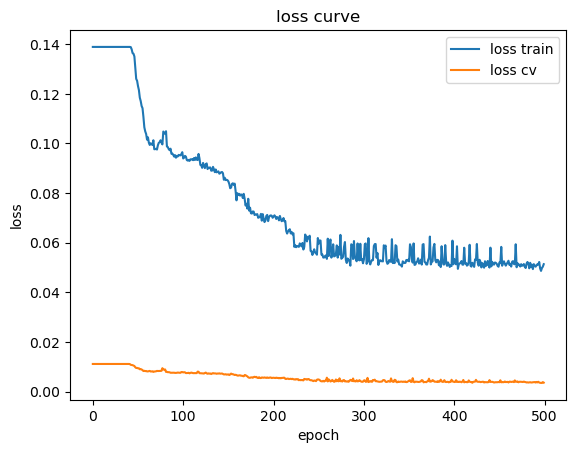

---------准确率accuracy随训练轮数epoch的变化图像---------


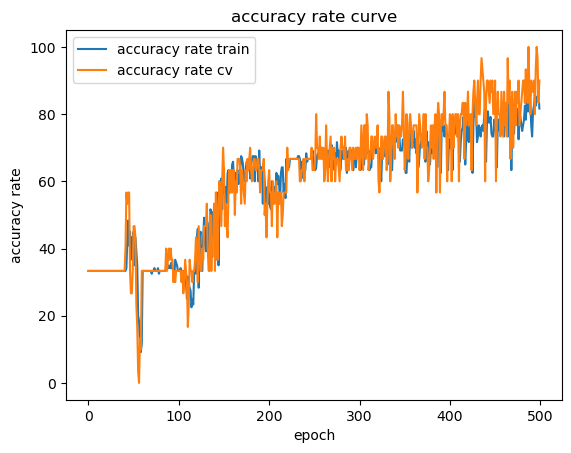

In [72]:
# 画出loss曲线
print("---------损失函数Loss随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), loss_train_store, np.arange(epoch), loss_cv_store)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["loss train", "loss cv"])
plt.title("loss curve")
plt.show()

# 画出accuracy曲线
print("---------准确率accuracy随训练轮数epoch的变化图像---------")
plt.plot(np.arange(epoch), accuracy_rate_train_store, np.arange(epoch), accuracy_rate_cv_store)
plt.xlabel("epoch")
plt.ylabel("accuracy rate")
plt.legend(["accuracy rate train", "accuracy rate cv"])
plt.title("accuracy rate curve")
plt.show()

In [ ]:
# 自定义等级量化函数
def quantize_weights(model, int_min=-7, int_max=7):
    """
    将模型权重量化为指定整数范围
    Args:
        model: PyTorch模型
        int_min: 最小整数值 (默认-7)
        int_max: 最大整数值 (默认7)
    Returns:
        量化后的模型
    """
    # 缩放因子记录数组
    scale_arr = torch.zeros(2)
    scale_index = 0

    with torch.no_grad():
        for name, param in model.named_parameters():
            # 计算权重的绝对最大值
            max_abs = torch.max(torch.abs(param.data))
            
            # 计算缩放因子，将最大值映射到 int_max
            scale = int_max / max_abs

            # 记录缩放因子scale，方便后续SNN神经元缩放阈值电压
            scale_arr[scale_index] = scale
            scale_index += 1
            
            # 缩放、四舍五入、截断到指定范围
            quantized = torch.round(param.data * scale)
            quantized = torch.clamp(quantized, min=int_min, max=int_max)
            
            # 替换原始权重（确保更新）
            param.data.copy_(quantized)

    # 将SNN神经元的阈值电压进行相同的量化变换（阈值电压无需四舍五入操作）
    net.lif_layer_1.v_threshold = net.lif_layer_1.v_threshold * scale_arr[0]
    net.lif_layer_1.v_threshold = torch.clamp(net.lif_layer_1.v_threshold, min=int_min, max=int_max)

    net.lif_layer_2.v_threshold = net.lif_layer_2.v_threshold * scale_arr[1]
    net.lif_layer_2.v_threshold = torch.clamp(net.lif_layer_2.v_threshold, min=int_min, max=int_max)

    print("量化完成！")

In [74]:
# 加载某一轮训练的模型
# net = torch.load("model_save/auto_save/model_auto_save_acc100.pth")
# net = torch.load("model_save/history_save/model_save_acc93_original.pth")

# 输出原始linear_1层权重
print("原始linear_1权重")
print(net.linear_1.weight.data)

# 输出原始lif_1层阈值电压
print(f"原始lif_1层阈值电压={net.lif_layer_1.v_threshold}")

# 输出原始linear_2层权重
print("原始linear_2权重")
print(net.linear_2.weight.data)

# 输出原始lif_2层阈值电压
print(f"原始lif_2层阈值电压={net.lif_layer_2.v_threshold}")

原始linear_1权重
tensor([[ 0.1059, -0.6766,  1.7453,  1.9109],
        [ 0.6718,  2.8162, -1.4479, -2.0854],
        [ 0.7439,  0.0804,  0.6529, -1.0852],
        [ 1.1988,  0.7989,  1.5646,  1.5572]], device='cuda:0')
原始lif_1层阈值电压=1.0
原始linear_2权重
tensor([[-1.9992,  3.6183, -0.5841,  0.0770],
        [ 0.5703,  0.2793,  1.0361,  1.1452],
        [ 1.4502, -0.8238, -1.2467,  0.5852]], device='cuda:0')
原始lif_2层阈值电压=1.0


In [75]:
# 量化
quantize_weights(net, int_min=-8, int_max=8)

量化完成！


In [76]:
# 输出量化后linear_1层权重
print("量化后linear_1.weight权重")
print(net.linear_1.weight.data)

# 输出量化后lif_1层阈值电压
print(f"量化后lif_1层阈值电压={net.lif_layer_1.v_threshold}")

# 输出量化后linear_2层权重
print("量化后linear_2.weight权重")
print(net.linear_2.weight.data)

# 输出量化后lif_2层阈值电压
print(f"量化后lif_2层阈值电压={net.lif_layer_2.v_threshold}")

量化后linear_1.weight权重
tensor([[ 0., -2.,  5.,  5.],
        [ 2.,  8., -4., -6.],
        [ 2.,  0.,  2., -3.],
        [ 3.,  2.,  4.,  4.]], device='cuda:0')
量化后lif_1层阈值电压=2.840660572052002
量化后linear_2.weight权重
tensor([[-4.,  8., -1.,  0.],
        [ 1.,  1.,  2.,  3.],
        [ 3., -2., -3.,  1.]], device='cuda:0')
量化后lif_2层阈值电压=2.210967540740967


In [80]:
# 加载某一轮训练的模型进行预测
# net = torch.load("model_save/auto_save/model_auto_save_acc100.pth")
# net = torch.load("model_save/history_save/model_save_acc63.pth")

# 开始使用神经网络预测
net.eval()
# 总测试次数
test_step = 0
# 统计准确性
accuracy = 0
with torch.no_grad(): # 预测阶段不进行梯度下降
    inputs = input_test
    labels = label_test
    inputs = inputs.to(device) # 将数据转换
    labels = labels.to(device) # 将数据转换
    label_onehot = F.one_hot(labels, 3).float()
    out_fr = 0.0
    for t in range(T):
        encoded_inputs = encoder(inputs)
        out_fr += net(encoded_inputs)
    output = out_fr / T
    # print(output)
    # 将分类概率转化为对应标签
    pred_label = output.argmax(1)
    # 每1次输出结果
    if (test_step%1==0):
        print("输出结果", pred_label)
        print("原始标签", labels)
    # 累加计算结果准确性
    accuracy += (pred_label == labels).sum()
    test_step += 1

    # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
    functional.reset_net(net)

accuracy_rate = accuracy/len(input_test)
print("模型预测正确数", accuracy.item(), "模型测试总数", len(input_test))
print("模型预测准确率: %.2f%%" %(accuracy_rate.item()*100))

输出结果 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1], device='cuda:0')
原始标签 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2], device='cuda:0')
模型预测正确数 20 模型测试总数 30
模型预测准确率: 66.67%


In [81]:
# 某一次固定的编码后脉冲数据，避免因每次编码的输入数据随机而导致结果不同
# 输入数据记得加.，浮点数类型

index_10_layer_1 = torch.tensor(
             [[1., 1., 1., 0.], # 第0个时间步长
              [1., 0., 1., 0.], # 第1个时间步长
              [1., 1., 1., 0.], # 第2个时间步长
              [1., 1., 1., 0.], # 第3个时间步长
              [1., 1., 1., 0.], # 第4个时间步长
              [0., 1., 1., 0.], # 第5个时间步长
              [1., 1., 1., 0.], # 第6个时间步长
              [0., 0., 1., 1.], # 第7个时间步长
              [1., 1., 1., 1.], # 第8个时间步长
              [1., 1., 0., 0.], # 第9个时间步长
              [1., 1., 1., 0.], # 第10个时间步长
              [0., 0., 1., 1.], # 第11个时间步长
              [0., 1., 1., 1.], # 第12个时间步长
              [1., 1., 1., 0.], # 第13个时间步长
              [1., 1., 1., 0.], # 第14个时间步长
              [0., 1., 1., 0.], # 第15个时间步长
              [1., 0., 1., 0.], # 第16个时间步长
              [1., 1., 1., 0.], # 第17个时间步长
              [1., 0., 1., 0.], # 第18个时间步长
              [1., 1., 1., 0.], # 第19个时间步长
              [0., 0., 0., 0.], # 第20个时间步长
              [1., 1., 0., 0.], # 第21个时间步长
              [0., 1., 1., 0.], # 第22个时间步长
              [1., 0., 0., 0.], # 第23个时间步长
              [1., 0., 1., 1.], # 第24个时间步长
              [1., 1., 1., 0.], # 第25个时间步长
              [1., 0., 1., 0.], # 第26个时间步长
              [1., 0., 1., 1.], # 第27个时间步长
              [1., 1., 1., 0.], # 第28个时间步长
              [1., 1., 1., 1.]] # 第29个时间步长
              )

原始数据tensor([[1., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 0., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [0., 0., 1., 1.],
        [0., 1., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 1., 1., 0.],
        [0., 0., 0., 0.],
        [1., 1., 0., 0.],
        [0., 1., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 1.],
        [1., 1., 1., 0.],
        [1., 0., 1., 0.],
        [1., 0., 1., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]], device='cuda:0')
label: 0
该层神经元膜电压值
[[ 1.5        0.         2.         0.       ]
 [ 0.        -1.         0.         0.       ]
 [ 1.5        2.5        2.         0.       ]
 [ 2.25       0.         0.         0.

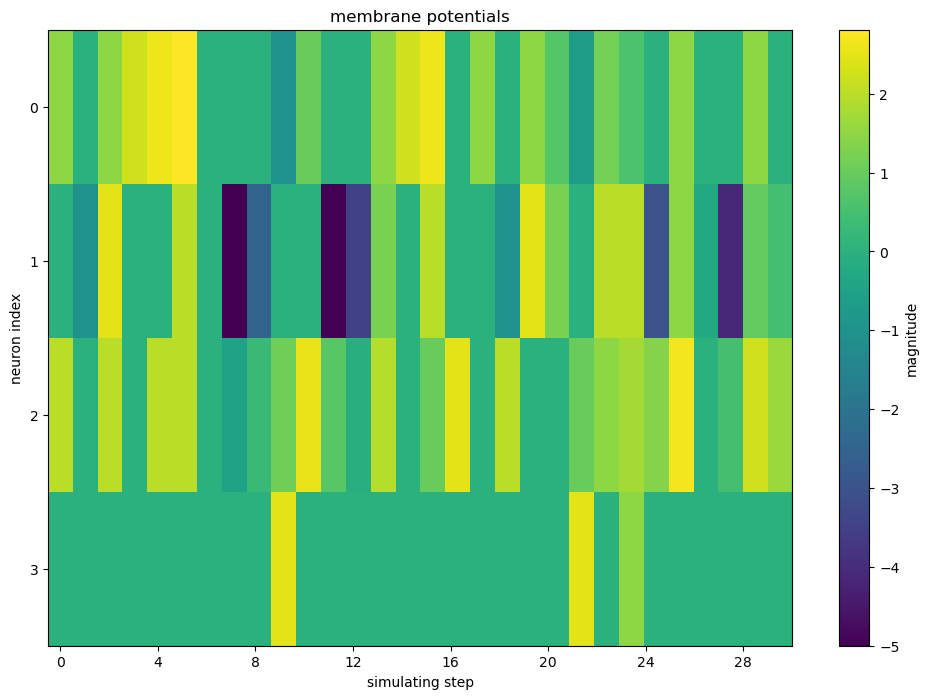

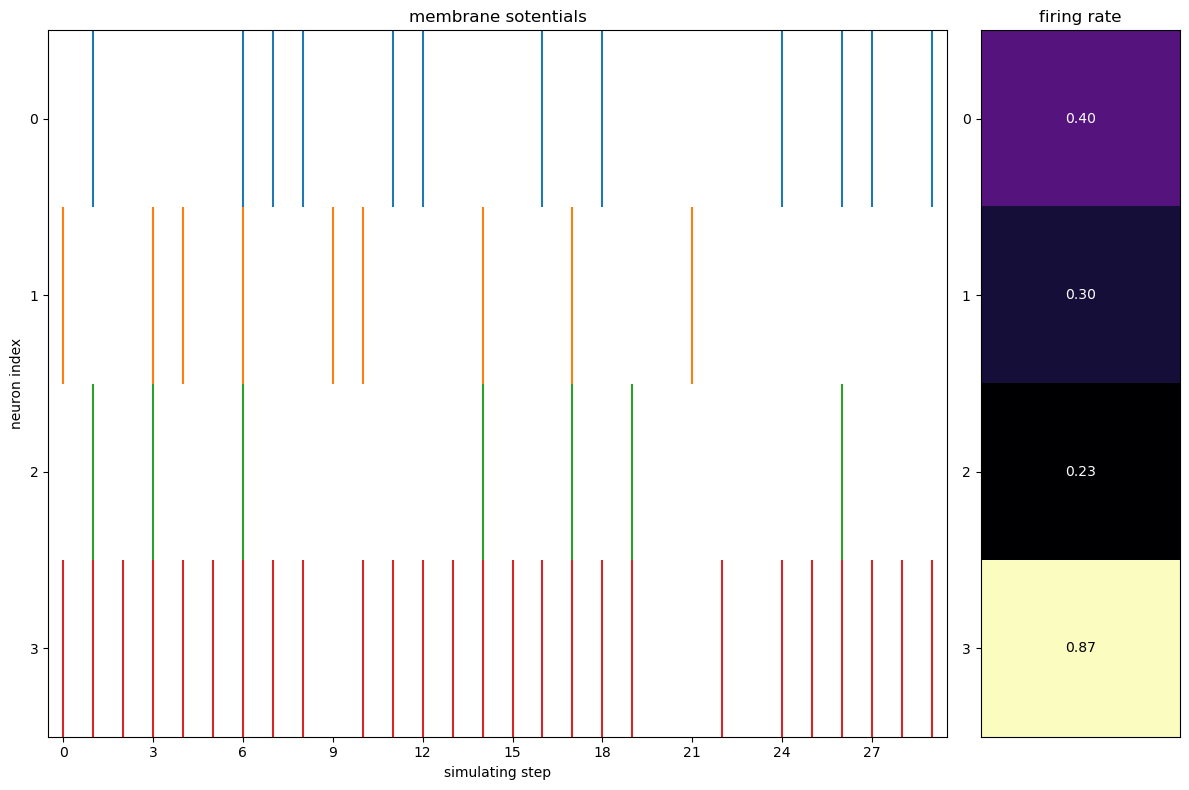

该层神经元膜电压值
[[ 0.          2.         -0.5       ]
 [-2.5         0.          0.25      ]
 [-1.25        1.5         0.625     ]
 [ 0.          0.         -1.6875    ]
 [ 0.          2.         -1.34375   ]
 [ 0.          0.         -0.171875  ]
 [ 1.5         0.         -0.5859375 ]
 [-1.25        2.          1.7070312 ]
 [-2.625       0.          0.        ]
 [ 0.          0.5        -1.        ]
 [ 0.          0.         -1.        ]
 [-2.          2.          1.5       ]
 [-3.          0.          0.        ]
 [-1.5         1.5         0.5       ]
 [ 0.          0.         -1.75      ]
 [ 0.          1.5        -0.375     ]
 [-2.          0.          1.8125    ]
 [ 0.          0.         -1.09375   ]
 [-2.          2.          1.453125  ]
 [-1.5         0.         -0.2734375 ]
 [-0.75        0.         -0.13671875]
 [ 0.          0.5        -1.0683594 ]
 [ 0.          1.75       -0.03417969]
 [ 0.          0.875      -0.01708984]
 [-2.          0.          1.9914551 ]
 [-1.          

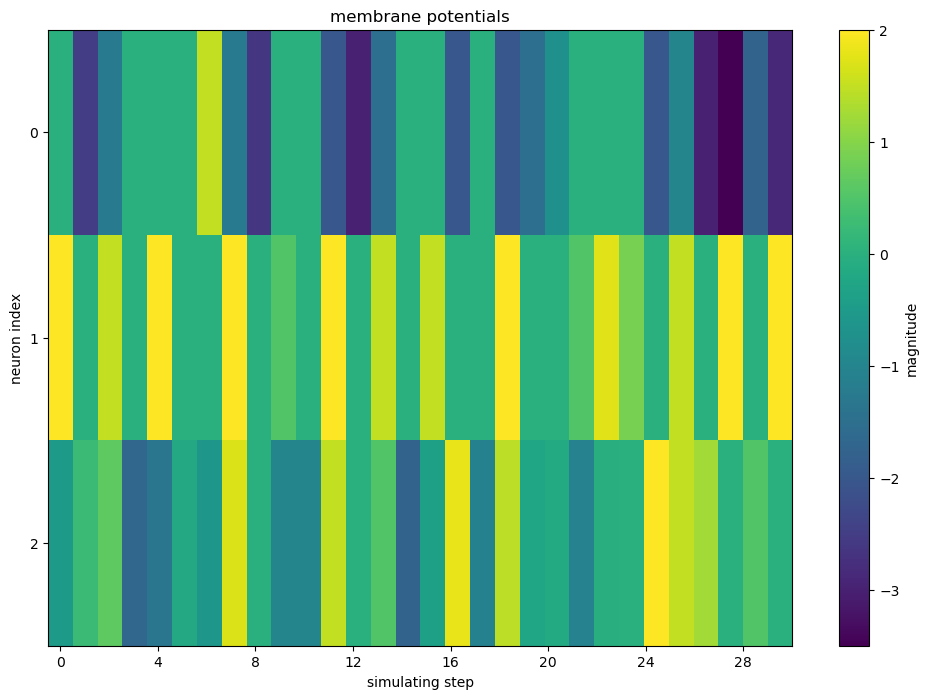

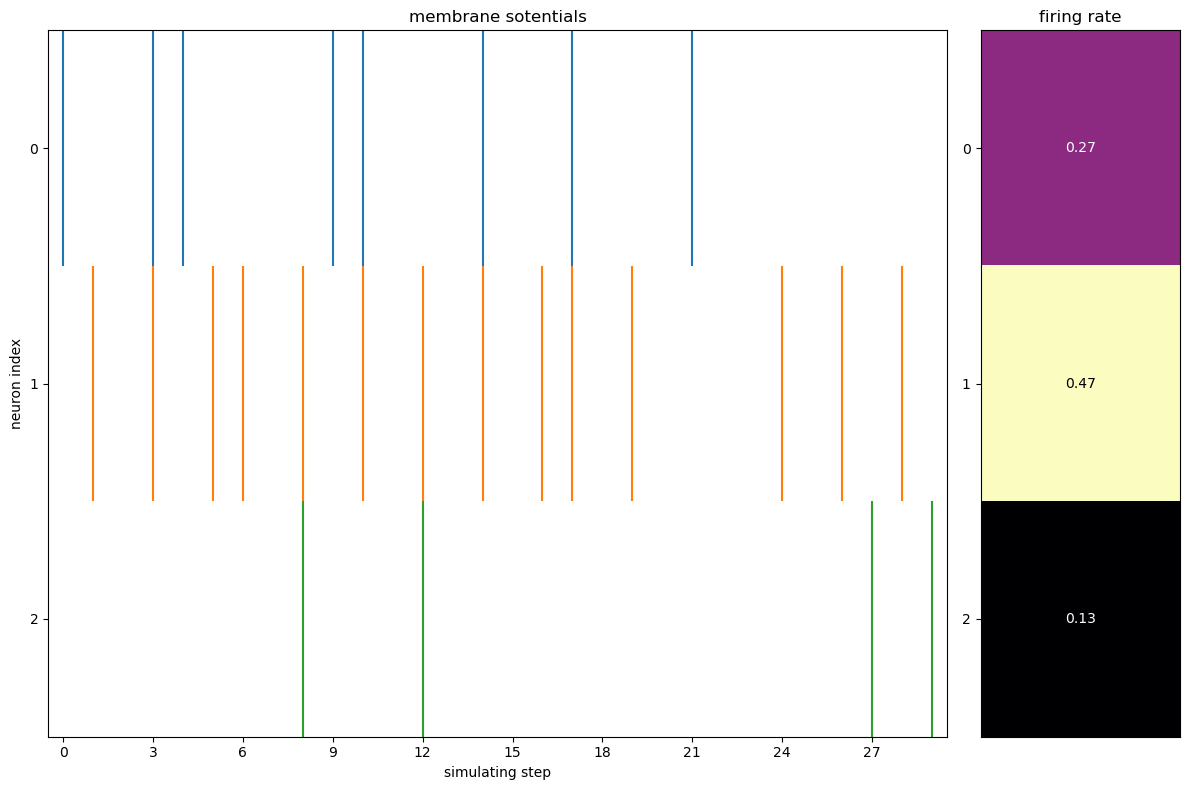

In [86]:
# 取出单个数据进行预测

# 载入原始数据
# 加载测试集中的单张图片
# 保存绘图用数据
net.eval()
# 注册第1层钩子
output_layer = net.lif_layer_1 # 输出层
output_layer.v_seq = []
output_layer.s_seq = []
def save_hook(m, x, y):
    m.v_seq.append(m.v.unsqueeze(0))
    m.s_seq.append(y.unsqueeze(0))

hook = output_layer.register_forward_hook(save_hook)

# 注册第2层钩子
output_layer_2 = net.lif_layer_2 # 输出层
output_layer_2.v_seq = []
output_layer_2.s_seq = []
def save_hook(m, x, y):
    m.v_seq.append(m.v.unsqueeze(0))
    m.s_seq.append(y.unsqueeze(0))

hook_2 = output_layer_2.register_forward_hook(save_hook)

# 加载测试集中的单个数据
index = 0
# input = input_test[index]
input = index_10_layer_1
input = input.to(device) # 将数据转换
print(f"原始数据{input}")
label = label_test[index]
label = label.to(device) # 将数据转换
print(f"label: {label}")

# 开始使用神经网络预测
net.eval()
with torch.no_grad(): # 预测阶段不进行梯度下降
    label_onehot = F.one_hot(label, 3).float()
    out_fr = 0.0
    for t in range(T):
        # encoded_input = encoder(input)
        # print(f"编码后的输入脉冲信号，第{t}个时间步长\n{encoded_input}")
        # out_fr += net(encoded_input)
        out_fr += net(input[t])
    output = out_fr / T

    # 输出第1层钩子
    output_layer.v_seq = torch.cat(output_layer.v_seq)
    output_layer.s_seq = torch.cat(output_layer.s_seq)
    v_t_array = output_layer.v_seq.cpu().numpy().squeeze()  # v_t_array[i][j]表示神经元i在j时刻的电压值
    print(f"该层神经元膜电压值\n{v_t_array}") # 输出膜电压值
    s_t_array = output_layer.s_seq.cpu().numpy().squeeze()  # s_t_array[i][j]表示神经元i在j时刻释放的脉冲，为0或1
    print(f"该层神经元脉冲\n{s_t_array}") # 输出脉冲

    # 膜电位热力图和输出脉冲结果
    figsize = (12, 8)
    dpi = 100
    visualizing.plot_2d_heatmap(array=v_t_array, title='membrane potentials', xlabel='simulating step',
                                ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


    visualizing.plot_1d_spikes(spikes=s_t_array, title='membrane sotentials', xlabel='simulating step',
                            ylabel='neuron index', figsize=figsize, dpi=dpi)

    plt.show()

    # 输出第2层钩子
    output_layer_2.v_seq = torch.cat(output_layer_2.v_seq)
    output_layer_2.s_seq = torch.cat(output_layer_2.s_seq)
    v_t_array = output_layer_2.v_seq.cpu().numpy().squeeze()  # v_t_array[i][j]表示神经元i在j时刻的电压值
    print(f"该层神经元膜电压值\n{v_t_array}") # 输出膜电压值
    s_t_array = output_layer_2.s_seq.cpu().numpy().squeeze()  # s_t_array[i][j]表示神经元i在j时刻释放的脉冲，为0或1
    print(f"该层神经元脉冲\n{s_t_array}") # 输出脉冲

    # 膜电位热力图和输出脉冲结果
    figsize = (12, 8)
    dpi = 100
    visualizing.plot_2d_heatmap(array=v_t_array, title='membrane potentials', xlabel='simulating step',
                                ylabel='neuron index', int_x_ticks=True, x_max=T, figsize=figsize, dpi=dpi)


    visualizing.plot_1d_spikes(spikes=s_t_array, title='membrane sotentials', xlabel='simulating step',
                            ylabel='neuron index', figsize=figsize, dpi=dpi)

    plt.show()

    # 优化一次参数后，需要重置网络的状态，因为SNN的神经元是有“记忆”的
    functional.reset_net(net)

hook.remove()
hook_2.remove()

In [ ]:
# 保存神经网络模型
# torch.save(net, "model_save/history_save/model_save_acc.pth")
# print("模型已保存")

In [87]:
# 查看网络参数
print(net)
net.named_parameters()
for name, param in net.named_parameters(prefix="mynet"):
    print(name, param)
    print(name, param.size())

Net(
  (linear_1): Linear(in_features=4, out_features=4, bias=False)
  (lif_layer_1): LIFNode(
    v_threshold=2.840660572052002, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
  (linear_2): Linear(in_features=4, out_features=3, bias=False)
  (lif_layer_2): LIFNode(
    v_threshold=2.210967540740967, v_reset=0.0, detach_reset=False, step_mode=s, backend=torch, tau=2.0
    (surrogate_function): ATan(alpha=2.0, spiking=True)
  )
)
mynet.linear_1.weight Parameter containing:
tensor([[ 0., -2.,  5.,  5.],
        [ 2.,  8., -4., -6.],
        [ 2.,  0.,  2., -3.],
        [ 3.,  2.,  4.,  4.]], device='cuda:0', requires_grad=True)
mynet.linear_1.weight torch.Size([4, 4])
mynet.linear_2.weight Parameter containing:
tensor([[-4.,  8., -1.,  0.],
        [ 1.,  1.,  2.,  3.],
        [ 3., -2., -3.,  1.]], device='cuda:0', requires_grad=True)
mynet.linear_2.weight torch.Size([3, 4])


In [ ]:
# 清除显存
torch.cuda.empty_cache()